In [1]:
from kipoi_cadd.data import CaddDataset
import pyarrow as pa
import blosc
from matplotlib.ticker import FuncFormatter
import pandas as pd
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import time
import random

Using TensorFlow backend.


In [12]:
training_dir = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/"
lmdb_dir = training_dir + "lmdb"
all_ids_file = training_dir + "variant_ids.pkl"
big_csv = training_dir + "training_data.imputed.csv"
folder_many_csv = training_dir + "shuffle_splits/"
lmdb_variant_based = training_dir + "lmdb/data.mdb"
lmdb_batch_based = ""
sparse_matrix = training_dir + "sparse_all.npz"

## Data storage options
Here is a comparisson of the methods used to persist the whole dataset.
- One big csv file
- Multiple csv files
- LMDB (with 1 key -> 1 variant)
- LMDB (with 1 key -> 1 batch of variants)
- Sparse matrix as npz

### 1. File sizes

In [3]:
def sum_file_sizes(parent_folder, file_ext='.csv'):
    files = glob.glob(parent_folder + "/**/*" + file_ext)
    total_size = 0
    for file in tqdm(files):
        total_size += os.path.getsize(os.path.join(parent_folder, file))
    return total_size

In [ ]:
disk_spaces = {
    'big_csv': {'size': 0, 'pretty': "Big csv"},
    'many_csv': {'size': 0, 'pretty': "Multiple csv's"},
    'lmdb_variant': {'size': 0, 'pretty': "LMDB by variant"},
    'lmdb_batch': {'size': 0, 'pretty': "LMDB by batch"},
    'sparse_matrix': {'size': 0, 'pretty': "Sparse matrix"}
}
disk_spaces['big_csv']['size'] = os.path.getsize(big_csv)
disk_spaces['many_csv']['size'] = sum_file_sizes(folder_many_csv)
disk_spaces['lmdb_variant']['size'] = os.path.getsize(lmdb_variant_based)
disk_spaces['lmdb_batch']['size'] = os.path.getsize(lmdb_batch_based)
disk_spaces['sparse_matrix']['size'] = os.path.getsize(sparse_matrix)
disk_spaces

In [14]:
df = pd.DataFrame(data={
    'types': list(disk_spaces.keys()),
    'pretty': [val['pretty'] for val in list(disk_spaces.values())],
    'spaces': [val['size'] for val in list(disk_spaces.values())],
    })
df.sort_values(by='spaces', inplace=True)
df

,types,pretty,spaces
3,lmdb_batch,LMDB by batch,0
4,sparse_matrix,Sparse matrix,3068938172
0,big_csv,Big csv,79893951115
1,many_csv,Multiple csv's,80237677004
2,lmdb_variant,LMDB by variant,289145520128


In [6]:
def gigabytes(x, pos):
    'The two args are the value and tick position'
    return '%3.0f GB' % (x*1e-9)

formatter = FuncFormatter(gigabytes)

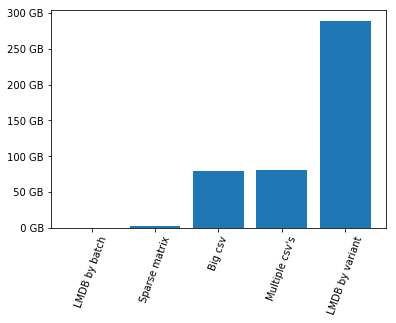

In [15]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(df.types, df.spaces);
plt.xticks(list(df.types), df.pretty,
           rotation=70)
plt.show()

### 1.1 Suplementary table

In [8]:
supp_table = df.sort_values(by='spaces', ascending=False)[['pretty', 'spaces']]
supp_table = supp_table.rename(columns={'pretty': "Storage approach", 'spaces': "Space in disk (bytes)"})
supp_table

,Storage approach,Space in disk (bytes)
2,LMDB by variant,289145520128
1,Multiple csv's,80237677004
0,Big csv,79893951115
3,LMDB by batch,0
4,Sparse matrix,0


### 2. Load time per option
We will test load times for 1 variant, 64, 1000, 100000, and 10000000 variants for all options listed above.

In [9]:
# LMDB by variant
ds = CaddDataset(lmdb_dir, all_ids_file)
idx = random.randint(1, 9999)
start = time.time()
item = ds.__getitem__(idx)
end = time.time()
disk_spaces['lmdb_variant']['load_1'] = end - start
print(end - start)

0.06651639938354492


In [10]:
# Multiple csv's

In [11]:
# Big csv

In [16]:
# LMDB by batch

In [ ]:
# Sparse matrix